# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

## Business Understanding

* Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
    * If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.


* What business problem(s) will this Data Science project solve for the organization?
    * What factors maximize a home's value?
    

* What problems are inside the scope of this project?
* What problems are outside the scope of this project?
* What data sources are available to us?
* What is the expected timeline for this project? Are there hard deadlines (e.g. "must be live before holiday season shopping") or is this an ongoing project?
* Do stakeholders from different parts of the company or organization all have the exact same understanding about what this project is and isn't?

## Data Understanding

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../src/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
len(df)

21597

In [4]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
years = sorted(df.yr_built.value_counts().index)

In [9]:
min(years)

1900

In [10]:
max(years)

2015

In [12]:
df.corr().price

id              -0.016772
price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
waterfront       0.276295
view             0.395734
condition        0.036056
grade            0.667951
sqft_above       0.605368
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
lat              0.306692
long             0.022036
sqft_living15    0.585241
sqft_lot15       0.082845
Name: price, dtype: float64

Highest correlations with price: (highest to lowest)
* sqft_living
* grade
* sqft_above
* sqft_living15

In [15]:
# not a great distribution of condition qualities-- what does a '3' mean?
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [17]:
df.yr_built.value_counts()

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

Text(0.5, 1.0, 'Year Built vs Average Price')

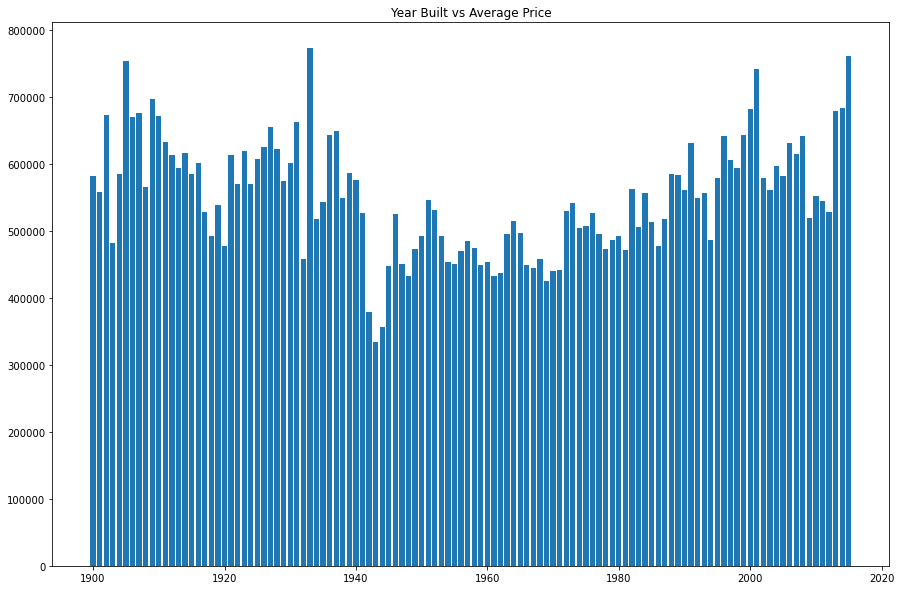

In [24]:
# Avg Sale Price vs Year built
avg_prices = [df['price'][df['yr_built']==year].mean() for year in years]
years = sorted(df.yr_built.value_counts().index)

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(years, avg_prices)
ax.set_title('Year Built vs Average Price')

<AxesSubplot:xlabel='price', ylabel='Count'>

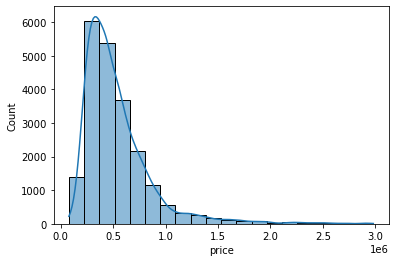

In [31]:
# Distribution of prices
sns.histplot(df['price'][df['price']<3000000], bins=20, kde=True)

## Data Prep

## Modeling